# Skracające sztuczne sieci neuronowe

Urszula Kicinger, Bartłomiej Wiśniewski


## **Cel projektu**

Celem projektu była implementacja sieci neuronowej, która generuje hash dla danego obrazu. Zaimplementowana sieć była trenowana na zbiorze zdjęć psów - Stanford Dogs (https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset).

## Import potrzebnych bibliootek

In [2]:
%pip install opencv-python tqdm

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, Subset
from torch import nn
from cv2 import imread
import matplotlib.pyplot as plt
import io

import random

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import xml.etree.ElementTree as ET
import tqdm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Przygotowanie zbioru danych

In [ ]:
def crop_image(image, bndbox):
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    return image[ymin:ymax, xmin:xmax]


class StanfordDogsDataset(Dataset):
    def __init__(self, root_dir, limit_classes=10000, limit_img_per_class=10000, transform=None):
        self.root_dir = root_dir
        self.img_names = []
        self.bndx = []
        self.breed = []
        self.label_to_idx = dict()
        self.transform = transform

        annotations_dir = os.path.join(self.root_dir, 'annotations', 'Annotation')
        images_dir = os.path.join(self.root_dir, 'images', 'Images')

        annotations = os.listdir(annotations_dir)
        for _, annotation_dir_name in zip(range(limit_classes), annotations):
            category_img_dir = os.path.join(images_dir, annotation_dir_name)
            annotation_dir = os.path.join(annotations_dir, annotation_dir_name)
            images_names = os.listdir(category_img_dir)

            for _, image_name in zip(range(limit_img_per_class), images_names):
                ann = ET.parse(os.path.join(annotation_dir, image_name.split('.')[0])).getroot()
                obj = ann.find('object')
                name = obj.find('name').text
                bndbox = obj.find('bndbox')

                if name not in self.label_to_idx:
                    self.label_to_idx[name] = len(self.label_to_idx)


                self.img_names.append(os.path.join(category_img_dir, image_name))
                self.bndx.append(bndbox)
                self.breed.append(name)


    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ann = self.breed[idx]
        bndbox = self.bndx[idx]

        img = imread(self.img_names[idx])
        img = crop_image(img, bndbox)


        if self.transform:
            img = self.transform(img)

        return img.to(torch.float), self.label_to_idx[ann]

## Stworzenie modelu sieci CNN

In [17]:
# CNN model
class HashingNet(torch.nn.Module):
    def __init__(self, encoding_size, conv_kernel_size = 3, input_channels=3):
        super().__init__()
        self.encoding_size = encoding_size
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(input_channels, 32, conv_kernel_size, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, conv_kernel_size, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, conv_kernel_size, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(1, 3),
            torch.nn.Linear(6272, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, encoding_size),
            torch.nn.Sigmoid(),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(encoding_size, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 6272),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (128,7,7)),

            torch.nn.ConvTranspose2d(128, 64, conv_kernel_size, 2),
            torch.nn.ReLU(),
            torch.nn.Upsample(size=(31,31)),

            torch.nn.ConvTranspose2d(64, 32, conv_kernel_size, 2),
            torch.nn.ReLU(),

            torch.nn.Upsample(size=(127,127)),

            torch.nn.ConvTranspose2d(32, input_channels, conv_kernel_size, 2),
            torch.nn.Upsample(size=(512,512)),

            torch.nn.ReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        if self.training:
            decoded = self.decoder(encoded)
            return decoded
        return encoded


class Classifier(torch.nn.Module):
    def __init__(self, input_channels=3, encoding_size=1024, classes=10, conv_kernel_size = 3):
        super().__init__()
        self.pool = torch.nn.MaxPool2d(2)
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten(1, 3)
        self.sigmoid = torch.nn.Sigmoid()

        self.conv1 = torch.nn.Conv2d(input_channels, 32, conv_kernel_size, 2)
        self.conv2 = torch.nn.Conv2d(32, 64, conv_kernel_size, 2)
        self.conv3 = torch.nn.Conv2d(64, 128, conv_kernel_size, 2)
        self.fc1 = torch.nn.Linear(6272, 2048)
        self.fc2 = torch.nn.Linear(2048, encoding_size)

        self.last = torch.nn.Linear(encoding_size, classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        x = self.last(x)

        return x

def accuracy_test(model, loader):
    model.eval()
    correct = 0
    total = 0

    subset = torch.utils.data.Subset(loader.dataset, random.sample(range(len(loader.dataset)), 200))
    with torch.no_grad():
        for data in torch.utils.data.DataLoader(subset):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total


def train_classifier(model, train_loader, optimizer, epochs=5, report_every=50):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(tqdm.tqdm(train_loader), 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % report_every == report_every-1:
                acc = accuracy_test(model, train_loader)
                tqdm.tqdm.write(f'[{epoch + 1}, {i + 1}] loss: {running_loss / i}, accuracy: {acc}')
        acc = accuracy_test(model, train_loader)
        tqdm.tqdm.write(f'[{epoch + 1}, {i + 1}] loss: {running_loss / i}, accuracy: {acc}')


def train_autoencoder(model, train_loader, optimizer, epochs=5):
    model.train()
    criterion = torch.nn.L1Loss()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(tqdm.tqdm(train_loader), 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        tqdm.tqdm.write(f'[{epoch + 1}, {i + 1}] loss: {running_loss / i}')


In [18]:
def transpose_conv_layer(conv_layer):
    """
    Transpose a pretrained Conv2d layer into a ConvTranspose2d layer.

    Args:
        conv_layer (nn.Conv2d): The pretrained Conv2d layer to transpose.

    Returns:
        nn.ConvTranspose2d: The transposed Conv2d layer as a ConvTranspose2d layer.
    """
    if not isinstance(conv_layer, nn.Conv2d):
        raise TypeError("The provided layer must be an instance of nn.Conv2d")

    # Extract weights and biases
    weights = conv_layer.weight
    biases = conv_layer.bias

    # Initialize a ConvTranspose2d layer
    conv_transpose = nn.ConvTranspose2d(
        in_channels=conv_layer.out_channels,
        out_channels=conv_layer.in_channels,
        kernel_size=conv_layer.kernel_size,
        stride=conv_layer.stride,
        padding=conv_layer.padding,
        output_padding=conv_layer.output_padding if hasattr(conv_layer, 'output_padding') else 0
    )
    conv_transpose.weight.data = conv_transpose.weight.data.to(device)
    conv_transpose.bias.data = conv_transpose.bias.data.to(device)

    # Copy weights and biases into the ConvTranspose2d layer
    # conv_transpose.weight.data = weights.data.T.contiguous()
    conv_transpose.weight.data = weights.data.clone()
    return conv_transpose



def copy_weights_from_classifier(classifier, hashing_net):
    with torch.no_grad():
        # Copy encoder weights
        hashing_net.encoder[0].weight.copy_(classifier.conv1.weight)
        hashing_net.encoder[0].bias.copy_(classifier.conv1.bias)

        hashing_net.encoder[3].weight.copy_(classifier.conv2.weight)
        hashing_net.encoder[3].bias.copy_(classifier.conv2.bias)

        hashing_net.encoder[6].weight.copy_(classifier.conv3.weight)
        hashing_net.encoder[6].bias.copy_(classifier.conv3.bias)

        hashing_net.encoder[10].weight.copy_(classifier.fc1.weight)
        hashing_net.encoder[10].bias.copy_(classifier.fc1.bias)

        hashing_net.encoder[12].weight.copy_(classifier.fc2.weight)
        hashing_net.encoder[12].bias.copy_(classifier.fc2.bias)

        # Copy decoder weights (transposed from encoder weights)
        hashing_net.decoder[0].weight.copy_(classifier.fc2.weight.T)
        hashing_net.decoder[2].weight.copy_(classifier.fc1.weight.T)
        hashing_net.decoder[5] = transpose_conv_layer(classifier.conv3)
        hashing_net.decoder[8] = transpose_conv_layer(classifier.conv2)
        hashing_net.decoder[11] = transpose_conv_layer(classifier.conv1)


def finalize_hash(hsh):
    hsh = hsh.detach().cpu()
    # hsh[hsh.abs() < hsh.abs().mean() / 10] = 0

    hsh = torch.round(hsh, decimals=0)

    return hsh

def compare(encoder, dataset, i1, i2):
    # get 2 random images and their label
    encoder.eval()
    img1, lab1 = dataset[i1]
    img2, lab2 = dataset[i2]

    # forward pass on 2 images
    output1 = encoder(img1.unsqueeze(0).to(device))
    output2 = encoder(img2.unsqueeze(0).to(device))

    output1_final = finalize_hash(output1)
    output2_final = finalize_hash(output2)

    # calculate cosine similarity
    cos = torch.nn.CosineSimilarity(dim=1)

    return {
        "same class": lab1 == lab2,
        "cos distance": cos(output1, output2),
        "cos distance of finalized": cos(output1_final, output2_final)
    }

## Trening modelu 1 (hash length: 64)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# dataset_path =

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512))
])

trainset = StanfordDogsDataset(dataset_path, limit_classes=10, limit_img_per_class=200, transform=data_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

In [ ]:
print("train dataset size:", len(trainset))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

encoding_size = 64
classifier = Classifier(encoding_size=encoding_size, classes=10).to(device)
hashNet = HashingNet(encoding_size=encoding_size).to(device)

cl_opt = torch.optim.Adam(classifier.parameters(), lr=0.001)

train dataset size: 1655


In [ ]:
train_classifier(classifier, train_loader, cl_opt, epochs=10)

 48%|████▊     | 50/104 [00:17<01:17,  1.44s/it]

[1, 50] loss: 2.2986933430846856, accuracy: 0.2


 96%|█████████▌| 100/104 [00:37<00:04,  1.23s/it]

[1, 100] loss: 2.1734754509396024, accuracy: 0.245


100%|██████████| 104/104 [00:38<00:00,  2.71it/s]


[1, 104] loss: 2.1699369694422748, accuracy: 0.205


 48%|████▊     | 50/104 [00:19<01:11,  1.33s/it]

[2, 50] loss: 2.0389074233113504, accuracy: 0.28


 96%|█████████▌| 100/104 [00:37<00:04,  1.24s/it]

[2, 100] loss: 2.0145273461486353, accuracy: 0.275


100%|██████████| 104/104 [00:39<00:00,  2.66it/s]


[2, 104] loss: 2.0111587093871774, accuracy: 0.25


 48%|████▊     | 50/104 [00:20<01:11,  1.33s/it]

[3, 50] loss: 1.9809849773134505, accuracy: 0.28


 96%|█████████▌| 100/104 [00:41<00:05,  1.49s/it]

[3, 100] loss: 1.9479193458653459, accuracy: 0.285


100%|██████████| 104/104 [00:42<00:00,  2.42it/s]


[3, 104] loss: 1.9469691665427198, accuracy: 0.27


 48%|████▊     | 50/104 [00:21<01:16,  1.41s/it]

[4, 50] loss: 1.9200788249774856, accuracy: 0.285


 96%|█████████▌| 100/104 [00:42<00:05,  1.44s/it]

[4, 100] loss: 1.8884763609279285, accuracy: 0.34


100%|██████████| 104/104 [00:43<00:00,  2.37it/s]


[4, 104] loss: 1.885472004853406, accuracy: 0.35


 48%|████▊     | 50/104 [00:21<01:20,  1.50s/it]

[5, 50] loss: 1.7985587047070872, accuracy: 0.36


 96%|█████████▌| 100/104 [00:44<00:05,  1.44s/it]

[5, 100] loss: 1.7773841547243523, accuracy: 0.455


100%|██████████| 104/104 [00:45<00:00,  2.28it/s]


[5, 104] loss: 1.7678221001208407, accuracy: 0.41


 48%|████▊     | 50/104 [00:22<01:17,  1.43s/it]

[6, 50] loss: 1.6308212547886127, accuracy: 0.46


 96%|█████████▌| 100/104 [00:46<00:06,  1.61s/it]

[6, 100] loss: 1.6232800881067913, accuracy: 0.49


100%|██████████| 104/104 [00:47<00:00,  2.17it/s]


[6, 104] loss: 1.6212046238982563, accuracy: 0.36


 48%|████▊     | 50/104 [00:21<01:20,  1.48s/it]

[7, 50] loss: 1.4576111375069132, accuracy: 0.525


 96%|█████████▌| 100/104 [00:45<00:06,  1.62s/it]

[7, 100] loss: 1.4379875816480079, accuracy: 0.625


100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


[7, 104] loss: 1.4414442198947794, accuracy: 0.61


 48%|████▊     | 50/104 [00:22<01:18,  1.45s/it]

[8, 50] loss: 1.284810056491774, accuracy: 0.685


 96%|█████████▌| 100/104 [00:45<00:05,  1.43s/it]

[8, 100] loss: 1.2701844669351674, accuracy: 0.715


100%|██████████| 104/104 [00:46<00:00,  2.23it/s]


[8, 104] loss: 1.2664966253401007, accuracy: 0.705


 48%|████▊     | 50/104 [00:23<01:25,  1.59s/it]

[9, 50] loss: 0.9816436463472794, accuracy: 0.745


 96%|█████████▌| 100/104 [00:46<00:05,  1.42s/it]

[9, 100] loss: 1.0014077021618082, accuracy: 0.785


100%|██████████| 104/104 [00:47<00:00,  2.18it/s]


[9, 104] loss: 1.002717100879521, accuracy: 0.805


 48%|████▊     | 50/104 [00:21<01:18,  1.46s/it]

[10, 50] loss: 0.7075331168515342, accuracy: 0.855


 96%|█████████▌| 100/104 [00:43<00:05,  1.43s/it]

[10, 100] loss: 0.7096743375966044, accuracy: 0.915


100%|██████████| 104/104 [00:44<00:00,  2.31it/s]


[10, 104] loss: 0.7054513371685176, accuracy: 0.9


## Fine-tuning modelu 1

In [ ]:
copy_weights_from_classifier(classifier, hashNet)

In [ ]:
optimizer = torch.optim.Adam(hashNet.parameters(), lr=0.001)
train_autoencoder(hashNet, train_loader, optimizer, epochs=5)

100%|██████████| 104/104 [00:41<00:00,  2.51it/s]


[1, 104] loss: 0.2614422570733191


100%|██████████| 104/104 [00:40<00:00,  2.55it/s]


[2, 104] loss: 0.17857944921961108


100%|██████████| 104/104 [00:42<00:00,  2.44it/s]


[3, 104] loss: 0.16594032118621382


100%|██████████| 104/104 [00:44<00:00,  2.33it/s]


[4, 104] loss: 0.15907029706297568


100%|██████████| 104/104 [00:42<00:00,  2.46it/s]

[5, 104] loss: 0.1549685961991838


In [ ]:
# 5 epochs more
for g in optimizer.param_groups:
    g['lr'] = 0.0001

train_autoencoder(hashNet, train_loader, optimizer, epochs=5)

100%|██████████| 104/104 [00:36<00:00,  2.83it/s]


[1, 104] loss: 0.15060787119911712


100%|██████████| 104/104 [00:37<00:00,  2.74it/s]


[2, 104] loss: 0.1495186311093349


100%|██████████| 104/104 [00:38<00:00,  2.71it/s]


[3, 104] loss: 0.1485856713600529


100%|██████████| 104/104 [00:40<00:00,  2.55it/s]


[4, 104] loss: 0.1475792276917152


100%|██████████| 104/104 [00:41<00:00,  2.51it/s]

[5, 104] loss: 0.14672433505359206


## Analiza wyników

In [ ]:
compare(hashNet, trainset, 11, 12)

{'same class': True,
 'cos distance': tensor([0.8502], device='cuda:0', grad_fn=<SumBackward1>),
 'cos distance of finalized': tensor([0.8141])}

In [ ]:
compare(hashNet, trainset, 11, 200)

{'same class': False,
 'cos distance': tensor([0.6761], device='cuda:0', grad_fn=<SumBackward1>),
 'cos distance of finalized': tensor([0.6356])}

In [ ]:
img = trainset[0][0]
img = img[None, :, :, :]
img = img.to(device)
hashNet.eval()
hsh = hashNet(img)
print(hsh)

tensor([[4.2076e-01, 9.8928e-01, 9.9998e-01, 9.9708e-01, 9.9986e-01, 9.9906e-01,
         3.2486e-02, 3.5424e-03, 9.9390e-01, 9.4454e-02, 4.9097e-12, 1.0000e+00,
         9.4347e-10, 4.4404e-04, 4.0516e-01, 8.5515e-01, 1.0000e+00, 8.9115e-01,
         1.0000e+00, 9.1710e-01, 1.0000e+00, 3.7932e-03, 1.0000e+00, 9.0223e-04,
         6.6172e-01, 6.4412e-02, 1.0000e+00, 1.0000e+00, 4.7105e-10, 1.0000e+00,
         8.0183e-02, 6.6749e-02, 7.2620e-01, 7.0867e-01, 1.0000e+00, 9.6097e-01,
         3.5433e-05, 6.4616e-05, 1.8170e-01, 9.4863e-01, 8.2738e-02, 3.5152e-01,
         1.0000e+00, 4.4304e-02, 8.4006e-06, 9.9681e-01, 2.9332e-01, 1.1919e-07,
         9.9975e-01, 7.1278e-06, 8.0427e-01, 1.0278e-09, 7.2661e-01, 3.4869e-02,
         1.0000e+00, 4.3829e-03, 1.8096e-01, 9.7088e-01, 9.7808e-05, 1.6011e-01,
         9.9932e-01, 9.8741e-01, 9.9997e-01, 8.7092e-01]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


In [ ]:
def compare_with_reconstructions(trainset, hashNet):
    fig, ax = plt.subplots(2, 10)

    random_imgs = random.sample(range(len(trainset)), 10)

    hashNet.train()
    for i, idx in enumerate(random_imgs):
        img = trainset[idx][0]
        img = img[None, :, :, :]
        img = img.to(device)
        decoded = hashNet(img)
        decoded = torch.squeeze(decoded)
        ax[0][i].imshow(trainset[idx][0].permute(1, 2, 0))
        ax[1][i].imshow(decoded.cpu().permute(1, 2, 0).detach().numpy())

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


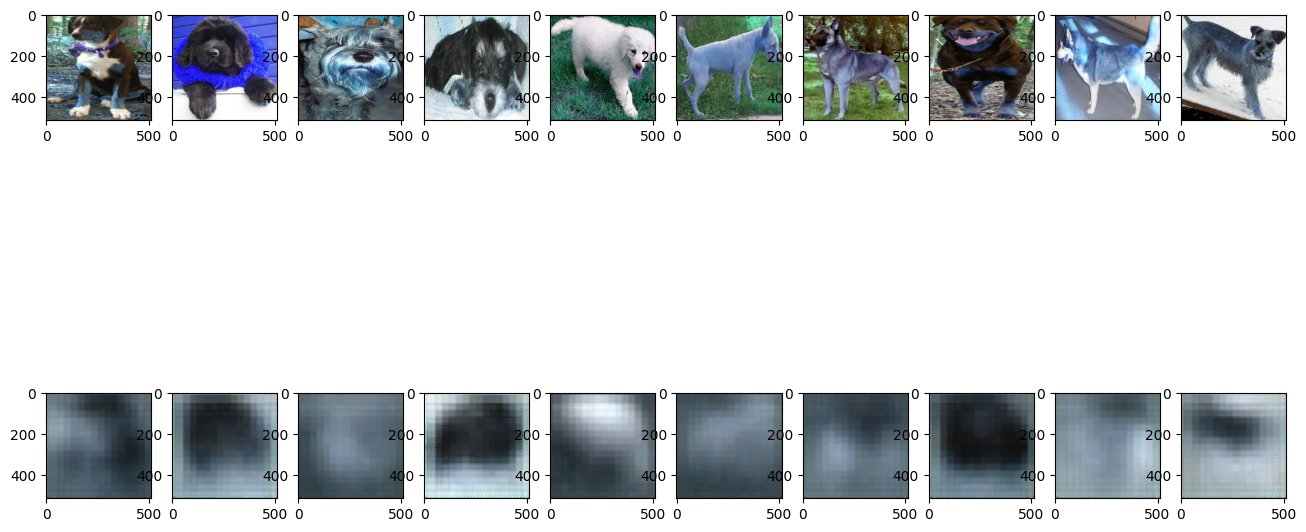

In [ ]:
encoded_imgs = []
decoded_imgs = []

plt.rcParams["figure.figsize"] = [16, 9]


compare_with_reconstructions(trainset, hashNet)

In [ ]:
myHash = ""
hsh_norm = torch.round(hsh.squeeze() * 62 + 48).to(torch.int32)
for i in range(encoding_size):
    let = hsh_norm[i] + 7*int(84 > hsh_norm[i] > 57) + 13*int(83 < hsh_norm[i])
    myHash += chr(let)

In [ ]:
myHash

## Model 2 (hash length: 512)

In [ ]:
encoding_size=512
cl2 = Classifier(encoding_size=encoding_size, classes=10).to(device)
hshNet2 = HashingNet(encoding_size=encoding_size).to(device)

In [ ]:
cl2_opt = torch.optim.Adam(cl2.parameters(), lr=0.001)
train_classifier(cl2, train_loader, cl2_opt, epochs=10)

 48%|████▊     | 50/104 [00:20<01:19,  1.48s/it]

[1, 50] loss: 1.9722525878828399, accuracy: 0.3


 96%|█████████▌| 100/104 [00:42<00:05,  1.47s/it]

[1, 100] loss: 1.9354927058171745, accuracy: 0.365


100%|██████████| 104/104 [00:43<00:00,  2.37it/s]


[1, 104] loss: 1.9293181583719345, accuracy: 0.355


 48%|████▊     | 50/104 [00:22<01:05,  1.21s/it]

[2, 50] loss: 1.8073152133396693, accuracy: 0.345


 96%|█████████▌| 100/104 [00:38<00:05,  1.29s/it]

[2, 100] loss: 1.7850440740585327, accuracy: 0.4


100%|██████████| 104/104 [00:39<00:00,  2.60it/s]


[2, 104] loss: 1.783951141301868, accuracy: 0.39


 48%|████▊     | 50/104 [00:18<00:58,  1.08s/it]

[3, 50] loss: 1.6724890616475319, accuracy: 0.415


 96%|█████████▌| 100/104 [00:38<00:05,  1.46s/it]

[3, 100] loss: 1.6395937999089558, accuracy: 0.405


100%|██████████| 104/104 [00:39<00:00,  2.62it/s]


[3, 104] loss: 1.6355662027609001, accuracy: 0.485


 48%|████▊     | 50/104 [00:26<01:44,  1.93s/it]

[4, 50] loss: 1.4324237302858003, accuracy: 0.485


 96%|█████████▌| 100/104 [01:00<00:10,  2.55s/it]

[4, 100] loss: 1.4373760662897668, accuracy: 0.57


100%|██████████| 104/104 [01:02<00:00,  1.67it/s]


[4, 104] loss: 1.4222135566970677, accuracy: 0.54


 48%|████▊     | 50/104 [00:18<01:03,  1.17s/it]

[5, 50] loss: 1.254610156526371, accuracy: 0.595


 96%|█████████▌| 100/104 [00:39<00:06,  1.51s/it]

[5, 100] loss: 1.2603003015421859, accuracy: 0.735


100%|██████████| 104/104 [00:40<00:00,  2.56it/s]


[5, 104] loss: 1.2673801079537104, accuracy: 0.7


 48%|████▊     | 50/104 [00:19<00:55,  1.02s/it]

[6, 50] loss: 0.9886398887147709, accuracy: 0.71


 96%|█████████▌| 100/104 [00:35<00:03,  1.04it/s]

[6, 100] loss: 0.9696297943592072, accuracy: 0.725


100%|██████████| 104/104 [00:36<00:00,  2.84it/s]


[6, 104] loss: 0.973792007536564, accuracy: 0.775


 48%|████▊     | 50/104 [00:15<00:51,  1.04it/s]

[7, 50] loss: 0.7160506041682496, accuracy: 0.85


 96%|█████████▌| 100/104 [00:32<00:03,  1.07it/s]

[7, 100] loss: 0.7117067852405586, accuracy: 0.845


100%|██████████| 104/104 [00:33<00:00,  3.11it/s]


[7, 104] loss: 0.715001020616698, accuracy: 0.85


 48%|████▊     | 50/104 [00:16<00:57,  1.07s/it]

[8, 50] loss: 0.4508353816915531, accuracy: 0.935


 96%|█████████▌| 100/104 [00:33<00:04,  1.15s/it]

[8, 100] loss: 0.4225519063195797, accuracy: 0.89


100%|██████████| 104/104 [00:34<00:00,  3.02it/s]


[8, 104] loss: 0.42168280974175165, accuracy: 0.925


 48%|████▊     | 50/104 [00:16<00:57,  1.07s/it]

[9, 50] loss: 0.2285221521647609, accuracy: 0.975


 96%|█████████▌| 100/104 [00:32<00:04,  1.09s/it]

[9, 100] loss: 0.19634015169559102, accuracy: 0.97


100%|██████████| 104/104 [00:33<00:00,  3.06it/s]


[9, 104] loss: 0.19671765086467116, accuracy: 0.96


 48%|████▊     | 50/104 [00:16<00:58,  1.08s/it]

[10, 50] loss: 0.09318702166177789, accuracy: 0.995


 96%|█████████▌| 100/104 [00:33<00:04,  1.07s/it]

[10, 100] loss: 0.085298241981578, accuracy: 1.0


100%|██████████| 104/104 [00:34<00:00,  3.02it/s]


[10, 104] loss: 0.08362454887551879, accuracy: 0.995


In [ ]:
copy_weights_from_classifier(cl2, hshNet2)

In [ ]:
hn2_opt = torch.optim.Adam(hshNet2.parameters(), lr=0.0005)
train_autoencoder(hshNet2, train_loader, hn2_opt, epochs=5)

100%|██████████| 104/104 [00:35<00:00,  2.93it/s]


[1, 104] loss: 0.2968732313913049


100%|██████████| 104/104 [00:32<00:00,  3.21it/s]


[2, 104] loss: 0.19993545028191168


100%|██████████| 104/104 [00:32<00:00,  3.17it/s]


[3, 104] loss: 0.18218724718950327


100%|██████████| 104/104 [00:32<00:00,  3.18it/s]


[4, 104] loss: 0.17691716768787902


100%|██████████| 104/104 [00:33<00:00,  3.10it/s]

[5, 104] loss: 0.17319879080485373


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


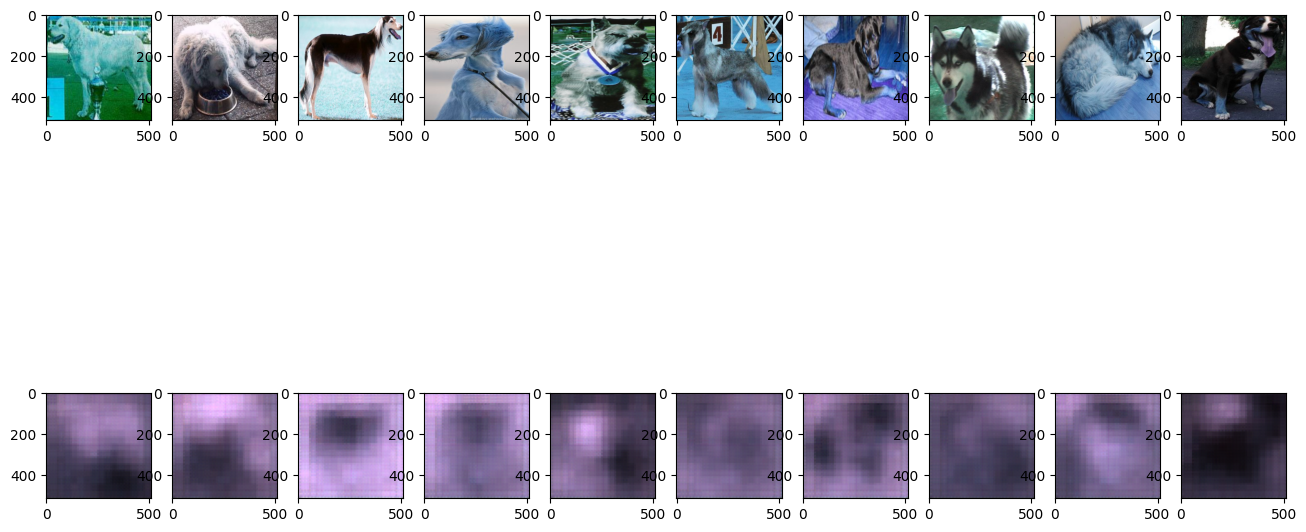

In [ ]:
plt.rcParams["figure.figsize"] = [16, 9]
compare_with_reconstructions(trainset, hshNet2)

In [ ]:
compare(hshNet2, trainset, 11, 12)

{'same class': True,
 'cos distance': tensor([0.8694], device='cuda:0', grad_fn=<SumBackward1>),
 'cos distance of finalized': tensor([0.8117])}

In [ ]:
compare(hshNet2, trainset, 11, 200)

{'same class': False,
 'cos distance': tensor([0.7182], device='cuda:0', grad_fn=<SumBackward1>),
 'cos distance of finalized': tensor([0.6673])}

# Simpler model on FashionMNIST

In [60]:
class MNISTHashNet(torch.nn.Module):
    def __init__(self, encoding_size):
        super().__init__()
        self.encoding_size = encoding_size
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Conv2d(32, 64, 3, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Flatten(1, 3),
            torch.nn.Linear(5*5*64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.encoding_size),
            torch.nn.Sigmoid()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.encoding_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 5*5*64),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (64,5,5)),

            torch.nn.ConvTranspose2d(64, 32, 3, 1),
            torch.nn.ReLU(),
            torch.nn.Upsample(size=(11,11)),

            torch.nn.ConvTranspose2d(32, 1, 3, 1),
            torch.nn.Upsample(size=(28,28)),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        if self.training:
            decoded = self.decoder(encoded)
            return decoded
        return encoded

## Preprocessing zbioru danych

In [61]:
from torchvision import datasets

fmnist_train = datasets.FashionMNIST('fashionMNIST', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]))

In [62]:
BATCH_SIZE = 512

In [63]:
fmnist_trainloader = torch.utils.data.DataLoader(fmnist_train, batch_size=BATCH_SIZE, shuffle=True)

## Model 1 (hash length: 64)

In [64]:
ENCODING_LENGTH = 64

### Trening modelu

In [65]:
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 10 == 9:
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 1000}')
                running_loss = 0.0

In [66]:
MNIST_hashNet = MNISTHashNet(ENCODING_LENGTH).to(device)

MNIST_hashNet.train()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(MNIST_hashNet.parameters(), lr=0.001)
train(MNIST_hashNet, fmnist_trainloader, criterion, optimizer, epochs=10)

[1, 10] loss: 0.00782274442911148
[1, 20] loss: 0.007375311493873596
[1, 30] loss: 0.007278391420841217
[1, 40] loss: 0.007268401563167572
[1, 50] loss: 0.00722585940361023
[1, 60] loss: 0.00725234043598175
[1, 70] loss: 0.007220378994941711
[1, 80] loss: 0.00721521919965744
[1, 90] loss: 0.007194666147232055
[1, 100] loss: 0.0072111933827400205
[1, 110] loss: 0.0071508846282958985
[2, 10] loss: 0.007171610713005066
[2, 20] loss: 0.007162916779518127
[2, 30] loss: 0.007143679141998291
[2, 40] loss: 0.007149306118488311
[2, 50] loss: 0.007167971730232239
[2, 60] loss: 0.007146196603775024
[2, 70] loss: 0.007136073112487793
[2, 80] loss: 0.00713236004114151
[2, 90] loss: 0.0071405510902404785
[2, 100] loss: 0.007137092530727387
[2, 110] loss: 0.007111130774021149
[3, 10] loss: 0.007087159335613251
[3, 20] loss: 0.007007543444633484
[3, 30] loss: 0.006980741024017334
[3, 40] loss: 0.006931152880191803
[3, 50] loss: 0.00691023725271225
[3, 60] loss: 0.006899707973003388
[3, 70] loss: 0.006

### Analiza wyników

Z obserwacji wynika, że wartości elementów wyjściowego wektora są albo bardzo bliskie 0, ablbo bardzo bliskie 1. Można więc je zaokrąglić do tych wartości co znacznie upraszcza dreprezentację i może zaoszczędzić pamięć, a równocześnie nie wpływa znacznie na odległość cosinusową poszczególnych skrótów. Wartość "cos distance of finalized" w poniższych komórkach jest odległością cosinusową po zastosowaniu tego zaokrąglenia.

In [67]:
compare(MNIST_hashNet, fmnist_train, 11, 12)

{'same class': False,
 'cos distance': tensor([0.7534], device='cuda:0', grad_fn=<SumBackward1>),
 'cos distance of finalized': tensor([0.2520])}

In [68]:
compare(MNIST_hashNet, fmnist_train, 11, 150)

{'same class': True,
 'cos distance': tensor([0.9161], device='cuda:0', grad_fn=<SumBackward1>),
 'cos distance of finalized': tensor([0.5897])}

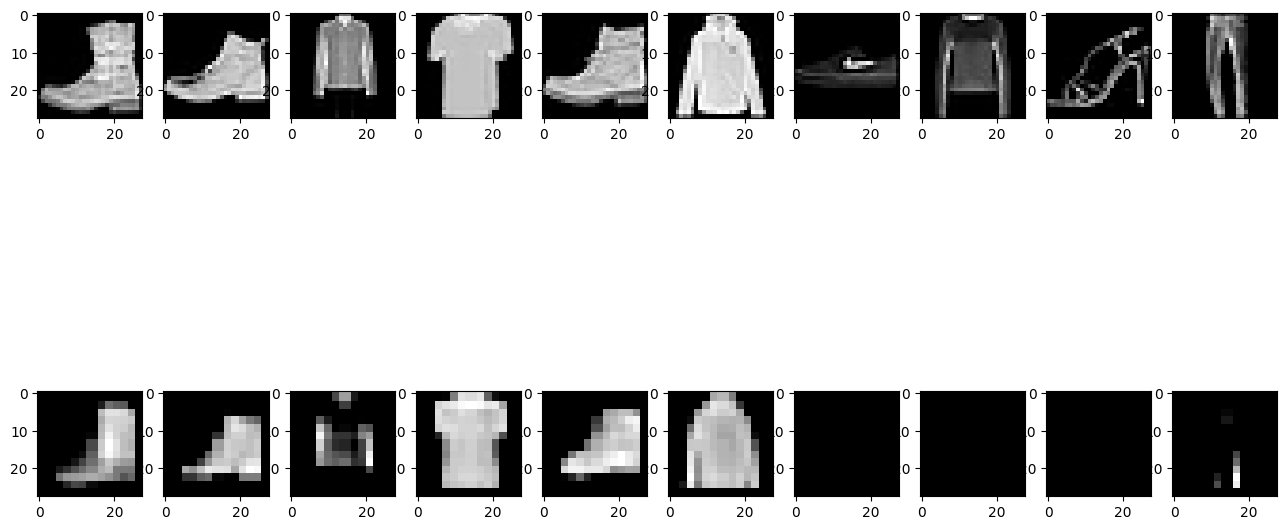

In [69]:
plt.rcParams["figure.figsize"] = [16, 9]
def compare_with_reconstructions(trainset, hashNet, dogs_set=True):
    fig, ax = plt.subplots(2, 10)

    random_imgs = random.sample(range(len(trainset)), 10)

    hashNet.train()
    for i, idx in enumerate(random_imgs):
        img = trainset[idx][0]
        img = img[None, :, :, :]
        img = img.to(device)
        decoded = hashNet(img)
        decoded = torch.squeeze(decoded)

        ax[0][i].imshow(trainset[idx][0].permute(1, 2, 0), cmap='gray')
        ax[1][i].imshow(decoded.cpu().detach().numpy(), cmap='gray')

    plt.show()

compare_with_reconstructions(fmnist_train, MNIST_hashNet)

In [52]:
img = fmnist_train[0][0]
img = img[None, :, :, :]
img = img.to(device)
MNIST_hashNet.eval()
hsh = MNIST_hashNet(img)
print(hsh)

tensor([[5.0465e-01, 9.6670e-01, 3.2975e-02, 3.5194e-03, 1.2183e-01, 2.5939e-04,
         1.3076e-01, 1.3411e-01, 5.3549e-01, 9.5334e-01, 9.5126e-01, 4.4041e-02,
         5.1104e-01, 9.1500e-03, 2.6487e-03, 4.4597e-03, 4.0652e-01, 2.3602e-01,
         9.0585e-03, 2.2318e-01, 2.1823e-03, 2.3052e-01, 1.2842e-04, 5.9281e-01,
         7.9808e-02, 8.3737e-04, 2.8013e-02, 7.7153e-03, 6.7456e-04, 1.3325e-03,
         7.7945e-02, 9.4497e-01, 1.3392e-01, 4.3120e-01, 3.8804e-03, 4.7838e-01,
         7.7276e-01, 6.1897e-02, 6.3212e-02, 2.1937e-01, 2.3350e-01, 9.9349e-01,
         1.9646e-01, 5.2793e-01, 8.7131e-02, 1.3850e-04, 2.1363e-01, 7.4691e-01,
         1.0903e-01, 2.8193e-05, 3.5860e-04, 3.2505e-03, 1.6922e-02, 3.5430e-02,
         3.0591e-01, 1.3210e-03, 1.0212e-01, 1.3065e-01, 1.6408e-01, 1.9702e-04,
         4.7216e-01, 4.2250e-05, 2.2848e-01, 1.2048e-01, 2.9483e-01, 4.3279e-04,
         2.0357e-01, 3.3588e-01, 5.1464e-01, 3.6854e-02, 5.8071e-03, 1.7004e-01,
         8.1685e-02, 5.0198e

## Model 2 (hash length: 512)

In [70]:
ENCODING_LENGTH = 512

### Trening modelu

In [71]:
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 10 == 9:
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 1000}')
                running_loss = 0.0

In [72]:
MNIST_hashNet = MNISTHashNet(ENCODING_LENGTH).to(device)

MNIST_hashNet.train()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(MNIST_hashNet.parameters(), lr=0.001)
train(MNIST_hashNet, fmnist_trainloader, criterion, optimizer, epochs=10)

[1, 10] loss: 0.0077373765110969545
[1, 20] loss: 0.007514001429080963
[1, 30] loss: 0.0074304136633872985
[1, 40] loss: 0.007318510830402374
[1, 50] loss: 0.00727204304933548
[1, 60] loss: 0.00716841983795166
[1, 70] loss: 0.007097998082637787
[1, 80] loss: 0.007061929225921631
[1, 90] loss: 0.006986190021038056
[1, 100] loss: 0.006976692259311676
[1, 110] loss: 0.006892263829708099
[2, 10] loss: 0.006879062950611114
[2, 20] loss: 0.006832533180713653
[2, 30] loss: 0.006822877883911132
[2, 40] loss: 0.006824791371822357
[2, 50] loss: 0.006811213374137879
[2, 60] loss: 0.0068095818161964415
[2, 70] loss: 0.0067985886931419375
[2, 80] loss: 0.006788300514221191
[2, 90] loss: 0.006775262176990509
[2, 100] loss: 0.006760484457015991
[2, 110] loss: 0.006746615409851074
[3, 10] loss: 0.00675591230392456
[3, 20] loss: 0.0067785983681678775
[3, 30] loss: 0.006771706104278565
[3, 40] loss: 0.006761036992073059
[3, 50] loss: 0.006732152223587036
[3, 60] loss: 0.006754642367362976
[3, 70] loss: 

### Analiza wyników

In [73]:
compare(MNIST_hashNet, fmnist_train, 11, 12)

{'same class': False,
 'cos distance': tensor([0.7342], device='cuda:0', grad_fn=<SumBackward1>),
 'cos distance of finalized': tensor([0.3447])}

In [74]:
compare(MNIST_hashNet, fmnist_train, 11, 150)

{'same class': True,
 'cos distance': tensor([0.9228], device='cuda:0', grad_fn=<SumBackward1>),
 'cos distance of finalized': tensor([0.7272])}

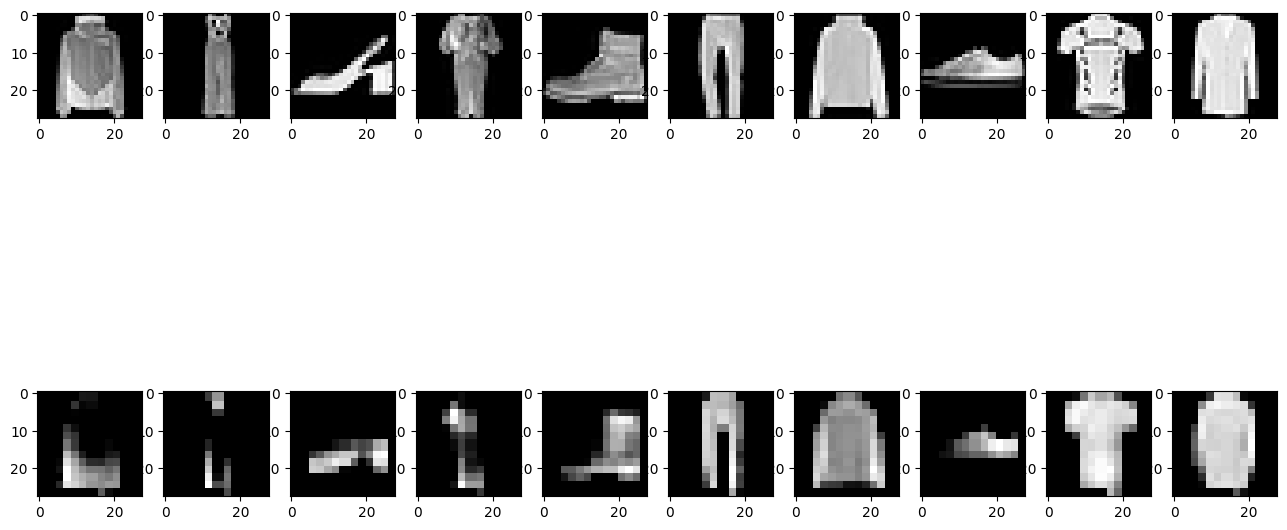

In [75]:
plt.rcParams["figure.figsize"] = [16, 9]
def compare_with_reconstructions(trainset, hashNet, dogs_set=True):
    fig, ax = plt.subplots(2, 10)

    random_imgs = random.sample(range(len(trainset)), 10)

    hashNet.train()
    for i, idx in enumerate(random_imgs):
        img = trainset[idx][0]
        img = img[None, :, :, :]
        img = img.to(device)
        decoded = hashNet(img)
        decoded = torch.squeeze(decoded)

        ax[0][i].imshow(trainset[idx][0].permute(1, 2, 0), cmap='gray')
        ax[1][i].imshow(decoded.cpu().detach().numpy(), cmap='gray')

    plt.show()

compare_with_reconstructions(fmnist_train, MNIST_hashNet)

In [76]:
img = fmnist_train[0][0]
img = img[None, :, :, :]
img = img.to(device)
MNIST_hashNet.eval()
hsh = MNIST_hashNet(img)
print(hsh)

tensor([[8.9540e-01, 6.8756e-01, 1.8775e-01, 4.3335e-01, 4.6548e-01, 5.1058e-01,
         2.4725e-01, 7.6401e-01, 3.5057e-02, 1.8697e-02, 1.0376e-01, 3.6718e-01,
         7.0557e-01, 6.3841e-01, 2.3098e-01, 1.1533e-01, 8.7774e-01, 2.6699e-01,
         4.6882e-01, 6.4286e-01, 2.7063e-01, 9.2128e-01, 1.8289e-01, 1.3006e-01,
         8.3040e-02, 1.3767e-01, 8.3288e-01, 5.4110e-01, 1.2536e-02, 5.7993e-01,
         6.4603e-01, 6.6129e-01, 4.0395e-01, 2.8331e-01, 4.6862e-01, 6.7581e-01,
         4.5849e-01, 5.2172e-01, 6.8291e-01, 1.2978e-01, 4.6437e-01, 1.8944e-01,
         3.2814e-01, 3.2473e-01, 1.0129e-02, 7.5440e-02, 7.6954e-01, 2.9874e-01,
         1.2601e-01, 4.0294e-01, 1.0493e-01, 5.7746e-01, 2.5903e-03, 5.9161e-01,
         3.7680e-01, 6.2604e-01, 7.5686e-01, 2.7650e-01, 7.7689e-01, 2.5980e-01,
         4.3361e-02, 2.9592e-02, 1.9552e-01, 1.1312e-01, 1.5748e-01, 4.4323e-01,
         4.8957e-01, 1.9685e-01, 6.0373e-01, 7.9031e-02, 6.8458e-01, 6.0801e-01,
         1.8988e-01, 4.0603e